---
**IntAct for yeast interactions**

---


https://www.ebi.ac.uk/intact/

- Format: PSI-MI TAB 2.7 http://psicquic.github.io/MITAB27Format.html

Codes for the columns:
- 9-10. NCBI Taxonomy https://www.ncbi.nlm.nih.gov/Taxonomy/CommonTree/wwwcmt.cgi

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
# from Bio import SeqIO
import requests
import urllib
import re
from io import StringIO
# import shutil
# import urllib.request as request
# from contextlib import closing
import gzip
from ftplib import FTP
import pickle as pkl
import math

from toolbox import *

%matplotlib inline
sns.set()
sns.set(rc={'figure.figsize':(14,6)})

KeyboardInterrupt: 

In [ ]:
cfg = load_cfg()

logVersions = load_LogVersions()

In [ ]:
sns.set(rc={'figure.figsize':(14,6)})

# Download data

In [ ]:
doDownload = False

In [ ]:
# Check timestamp

ftp = FTP('ftp.ebi.ac.uk')
ftp.login()
ftp.cwd('/pub/databases/intact/current/psimitab/')

intact_filename = 'intact.txt'
versionIntAct = ftp.voidcmd("MDTM " + intact_filename)[4:12]
print("Timestamp: {}".format(versionIntAct))
ftp.quit()

In [ ]:
if doDownload:
    ftp = FTP('ftp.ebi.ac.uk')
    ftp.login()
    ftp.cwd('/pub/databases/intact/current/psimitab/')

    intact_filename = 'intact.txt'
    # Collect timestamp
    versionIntAct = ftp.voidcmd("MDTM " + intact_filename)[4:12]
    print("Timestamp: {}".format(versionIntAct))

    localFile = os.path.join(cfg['rawDataIntact'], "intact_v{}.txt".format(versionIntAct))
    print("Download location: {}".format(localFile))

    with open(localFile, 'wb') as f:
        ftp.retrbinary('RETR ' + intact_filename, f.write, 1024)

    ftp.quit()

In [ ]:
if doDownload:
#     logVersions['IntAct'] = dict()
    logVersions['IntAct']['rawData'] = versionIntAct

    dump_LogVersions(logVersions)

# Preprocessing

In [ ]:
dfIntAct = pd.read_csv(os.path.join(cfg['rawDataIntact'],
                                    "intact_v{}.txt".format(logVersions['IntAct']['rawData'])), 
                       sep="\t")
glance(dfIntAct)

In [ ]:
dfIntAct.iloc[0,:]

## Filter 1: human PPIs with UniProtKB IDs

**Parse and filter UniProtKB IDs**

In [ ]:
dfIntAct["All IDs interactor A"] = dfIntAct["#ID(s) interactor A"] + "|" + dfIntAct["Alt. ID(s) interactor A"]
dfIntAct["All IDs interactor B"] = dfIntAct["ID(s) interactor B"] + "|" + dfIntAct["Alt. ID(s) interactor B"]

*Extract UniProtKB ID*

In [ ]:
regex1 = re.compile(r"(?<=uniprotkb:)[\w]+")

dfIntAct.loc[:,'uniprotkb_IDs_A'] = ['|'.join(m) for m in (re.findall(regex1, line) for line in dfIntAct.loc[:,"All IDs interactor A"])]
dfIntAct.loc[:,'uniprotkb_IDs_B'] = ['|'.join(m) for m in (re.findall(regex1, line) for line in dfIntAct.loc[:,"All IDs interactor B"])]

dfIntAct.loc[:,'first_uniprotkb_IDs_A'] = [m.group() if m else '' for m in (regex1.search(line) for line in dfIntAct.loc[:,"All IDs interactor A"])]
dfIntAct.loc[:,'first_uniprotkb_IDs_B'] = [m.group() if m else '' for m in (regex1.search(line) for line in dfIntAct.loc[:,"All IDs interactor B"])]

glance(dfIntAct)

*Remove interactions with missing IDs*

In [ ]:
foo = (dfIntAct.first_uniprotkb_IDs_A == '')|(dfIntAct.first_uniprotkb_IDs_B == '')

print('{:,}/{:,} ({:.1%}) of the interactions have at least one interactor without uniprotKB ID'.format(
    len(dfIntAct.loc[foo]),
    len(dfIntAct),
    len(dfIntAct.loc[foo])/len(dfIntAct)

))

In [ ]:
dfIntAct_1 = dfIntAct.loc[
    (dfIntAct.first_uniprotkb_IDs_A != '')&(dfIntAct.first_uniprotkb_IDs_B != '')
]
glance(dfIntAct_1)

---
**Yeast-Yeast interactions**

In [ ]:
# Sanity check
foo = list(set(dfIntAct_1['Taxid interactor A'].tolist() + dfIntAct_1['Taxid interactor A'].tolist()))
bar = [s for s in foo if ":559292" in s]
print(bar)
assert len(bar) == 1

In [ ]:
foo = 'taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)'
dfIntAct_2 = dfIntAct_1.loc[
    (dfIntAct_1['Taxid interactor A'] == foo)&(dfIntAct_1['Taxid interactor B'] == foo)
]
glance(dfIntAct_2)

---
**protein-protein interactions**

In [ ]:
print(dfIntAct_2.groupby(by="Type(s) interactor A").size().sort_values(ascending=False))
print(dfIntAct_2.groupby(by="Type(s) interactor B").size().sort_values(ascending=False))

In [ ]:
foo = 'psi-mi:"MI:0326"(protein)'
dfIntAct_3 = dfIntAct_2.loc[
    (dfIntAct['Type(s) interactor A'] == foo)&(dfIntAct['Type(s) interactor B'] == foo)
]
glance(dfIntAct_3)

---
**Confidence score** 

Details of intact mi-score: https://www.ebi.ac.uk/intact/pages/faq/faq.xhtml#9

*Pull names of scores*

In [ ]:
reConfScore = re.compile(r"(?<=\|)[-\s\w]+(?=:)")

confScoreNames =[val for sublist in [reConfScore.findall("|" + line) for line in dfIntAct_3["Confidence value(s)"]] for val in sublist]

set(confScoreNames)

*Pull intact-miscore values*

In [ ]:
reIntactMiscore = re.compile(r"(?<=intact-miscore:)[\d.]+")

dfIntAct_3.loc[:,'intact-miscore'] = [m.group() if m else 'NA' for m in (reIntactMiscore.search(line) for line in dfIntAct_3["Confidence value(s)"])]

# Sanity check
assert len(dfIntAct_3.loc[dfIntAct_3['intact-miscore'] == 'NA']) == 0

dfIntAct_3.loc[:,'intact-miscore'] = pd.to_numeric(dfIntAct_3['intact-miscore'])
dfIntAct_3['intact-miscore'][:5]

---
**Sanity checks**

In [ ]:
assert len(dfIntAct_3.loc[dfIntAct_3['Negative']]) == 0

---
**Reinitialise index**

In [ ]:
dfIntAct1 = dfIntAct_3.reset_index(drop=True)
glance(dfIntAct1)

## EDA

**Confidence score**

In [ ]:
sns.distplot(dfIntAct1['intact-miscore'], hist=False);

---
**Interaction type**

In [ ]:
dfIntAct1.groupby(by="Interaction type(s)").size().sort_values(ascending=False)

In [ ]:
l1 = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0914"(association)', 'psi-mi:"MI:0407"(direct interaction)']
foo = dfIntAct1.loc[dfIntAct1['Interaction type(s)'].isin(l1)]

l2 = ['psi-mi:"MI:0403"(colocalization)']
bar = dfIntAct1.loc[dfIntAct1['Interaction type(s)'].isin(l2)]

sns.distplot(foo['intact-miscore'], hist=False, rug=True, norm_hist=True, label='association')
sns.distplot(bar['intact-miscore'], hist=False, rug=True, norm_hist=True, label='colocalisation')
plt.legend();

In [ ]:
L = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0914"(association)', 'psi-mi:"MI:0407"(direct interaction)']

for l in L:
    foo = dfIntAct1.loc[dfIntAct1['Interaction type(s)'] == l]
    sns.distplot(foo['intact-miscore'], hist=False, label=l)
plt.legend();

---
**Complex expansion method**

Here we distinguish between true binary interactions and N-ary interactions

In [ ]:
dfIntAct_3["Expansion method(s)"].value_counts()

In [ ]:
l1 = ['-']
foo = dfIntAct1.loc[dfIntAct1['Expansion method(s)'].isin(l1)]

l2 = ['psi-mi:"MI:1060"(spoke expansion)']
bar = dfIntAct1.loc[dfIntAct1['Expansion method(s)'].isin(l2)]

sns.distplot(foo['intact-miscore'], hist=False, kde=True, norm_hist=True, label='Direct')
sns.distplot(bar['intact-miscore'], hist=False, kde=True, norm_hist=True, label='Spoke complexe')
plt.legend();

---
**detection method**

In [ ]:
dfIntAct1.groupby(by="Interaction detection method(s)").size().sort_values(ascending=False)

In [ ]:
L = [
    'psi-mi:"MI:0007"(anti tag coimmunoprecipitation)', 
    'psi-mi:"MI:0397"(two hybrid array)', 
    'psi-mi:"MI:1112"(two hybrid prey pooling approach)',
    'psi-mi:"MI:1356"(validated two hybrid)',
    'psi-mi:"MI:0006"(anti bait coimmunoprecipitation)',
    'psi-mi:"MI:0096"(pull down)',
    'psi-mi:"MI:0676"(tandem affinity purification)',
    'psi-mi:"MI:0018"(two hybrid)'
]

for l in L:
    foo = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'] == l]
    sns.distplot(foo['intact-miscore'], hist=False, label=l)
plt.legend();

In [ ]:
l1 = [
    'psi-mi:"MI:0007"(anti tag coimmunoprecipitation)',
    'psi-mi:"MI:0006"(anti bait coimmunoprecipitation)',
]
foo = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'].isin(l1)]

l2 = [
    'psi-mi:"MI:0397"(two hybrid array)', 
    'psi-mi:"MI:1112"(two hybrid prey pooling approach)',
    'psi-mi:"MI:1356"(validated two hybrid)',
    'psi-mi:"MI:0018"(two hybrid)'
]
bar = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'].isin(l2)]

l3 = ['psi-mi:"MI:0096"(pull down)',]
baar = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'].isin(l3)]

l4 = ['psi-mi:"MI:0676"(tandem affinity purification)',]
fool = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'].isin(l4)]

sns.distplot(foo['intact-miscore'], hist=False, label='coimmunoprecipitation')
sns.distplot(bar['intact-miscore'], hist=False, label='two hybrid')
sns.distplot(baar['intact-miscore'], hist=False, label='pull down')
sns.distplot(fool['intact-miscore'], hist=False, label='TAP')
plt.legend();

---
**Host organisms**

In [ ]:
dfIntAct1.groupby(by="Host organism(s)").size().sort_values(ascending=False)

In [ ]:
l1 = [
    'taxid:4932(yeasx)|taxid:4932("Saccharomyces cerevisiae (Baker\'s yeast)") ',
    'taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)'
]
foo = dfIntAct1.loc[dfIntAct1['Host organism(s)'].isin(l1)]

l2 = [
    'taxid:9606(human-293t)|taxid:9606(Homo sapiens 293 cells transformed with SV40 large T antigen)',
    'taxid:9606(human-293)|taxid:9606(Homo sapiens transformed primary embryonal kidney cells)',
    'taxid:9606(human-hela)|taxid:9606(Homo sapiens epitheloid cervix carcinoma cells)',
    'taxid:9606(human-293 flp-in)|taxid:9606(Homo sapiens)',
    'taxid:9606(human-u2-os)|taxid:9606(Human U2-OS osteosarcoma cell line)',
    'taxid:9606(human)|taxid:9606(Homo sapiens)'
]
bar = dfIntAct1.loc[dfIntAct1['Host organism(s)'].isin(l2)]

l3 = ['taxid:-1(in vitro)|taxid:-1(In vitro)']
baar = dfIntAct1.loc[dfIntAct1['Host organism(s)'].isin(l3)]

sns.distplot(foo['intact-miscore'], hist=False, label='yeast')
sns.distplot(bar['intact-miscore'], hist=False, label='homo sapiens')
sns.distplot(baar['intact-miscore'], hist=False, label='in vitro')
plt.legend();

**Mapping to UniProt** 

(copied from the "mapping to uniprot" section below, check it out for details)

In [ ]:
intactFinal = dfIntAct1[['first_uniprotkb_IDs_A','first_uniprotkb_IDs_B']]

uniprotkbIdsList = list(set(list(intactFinal.first_uniprotkb_IDs_A)+list(intactFinal.first_uniprotkb_IDs_B)))
assert ~('' in uniprotkbIdsList)

uniprotMapping = mappingUniprotIDs(fromID = 'ACC', listIDs = uniprotkbIdsList)

uniprotMapping_2 = uniprotMapping.drop_duplicates(subset='From',keep=False).reset_index(drop=True)

uniprotIDs = pd.read_csv(
    os.path.join(cfg['rawDataUniProt'], 
                 "uniprot_allProteins_Human_v{}.pkl".format(logVersions['UniProt']['rawData'])),
    header=None,
    names=['To']
)

uniprotMapping_3 = uniprotMapping_2.merge(
    uniprotIDs,
    how='inner',
    on='To'
)

print("{:,}/{:,} couldn't be matched".format(len(uniprotkbIdsList)-len(set(uniprotMapping.From)), len(uniprotkbIdsList)))
print('Droped duplicates: {:,}'.format(len(uniprotMapping) - len(uniprotMapping_2)))
print('Droped "unofficials": {:,}'.format(len(uniprotMapping_2) - len(uniprotMapping_3)))

assert len(uniprotMapping_2.loc[uniprotMapping_2.duplicated(keep=False)]) == 0
assert len(uniprotMapping_2.From) == len(set(uniprotMapping_2.From))

uniprotMapping_A = uniprotMapping_3.copy()
uniprotMapping_A = uniprotMapping_A.rename(columns={
    'From': 'first_uniprotkb_IDs_A', 
    'To': 'uniprotID_A'
})
uniprotMapping_B = uniprotMapping_3.copy()
uniprotMapping_B = uniprotMapping_B.rename(columns={
    'From': 'first_uniprotkb_IDs_B', 
    'To': 'uniprotID_B'
})

intactFinal_2 = intactFinal.merge(
    uniprotMapping_A,
    how="inner", 
    on="first_uniprotkb_IDs_A"
).merge(
    uniprotMapping_B,
    how="inner", 
    on="first_uniprotkb_IDs_B"
)

print('In total, {:,} interactions removed'.format(len(intactFinal) - len(intactFinal_2)))

assert len(intactFinal_2) < len(intactFinal)
assert intactFinal_2.uniprotID_A.isna().sum() == 0
assert intactFinal_2.uniprotID_B.isna().sum() == 0

In [ ]:
glance(intactFinal_2)

In [ ]:
allIDs = pd.concat([intactFinal_2.uniprotID_A,intactFinal_2.uniprotID_B])

Ninter_perProtein = allIDs.value_counts()

Ninter_perProtein

## Filter 2: no complexes and no colocalisation

**Keep only direct interactions (no complexe expensions)**

In [ ]:
dfIntAct1.shape

In [ ]:
dfIntAct1_2 = dfIntAct1.loc[dfIntAct1['Expansion method(s)'] == '-']
dfIntAct1_2.shape

---
**EDA part 2**

In [ ]:
dfIntAct1_2.groupby(by="Interaction type(s)").size().sort_values(ascending=False)

In [ ]:
l1 = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0914"(association)', 'psi-mi:"MI:0407"(direct interaction)']
foo = dfIntAct1_2.loc[dfIntAct1_2['Interaction type(s)'].isin(l1)]

l2 = ['psi-mi:"MI:0403"(colocalization)']
bar = dfIntAct1_2.loc[dfIntAct1_2['Interaction type(s)'].isin(l2)]

sns.distplot(foo['intact-miscore'], hist=False, rug=True, norm_hist=True, label='association')
sns.distplot(bar['intact-miscore'], hist=False, rug=True, norm_hist=True, label='colocalisation')
plt.legend();

In [ ]:
L = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0914"(association)', 'psi-mi:"MI:0407"(direct interaction)']

for l in L:
    foo = dfIntAct1_2.loc[dfIntAct1_2['Interaction type(s)'] == l]
    sns.distplot(foo['intact-miscore'], hist=False, label=l)
plt.legend();

---
**keep only associations, no colocalisations or other weird things**

(Although we already removed most of them by removing complexes, and histograms show no real low quality peak anymore)

In [ ]:
foo = [
    'psi-mi:"MI:0915"(physical association)', 
    'psi-mi:"MI:0914"(association)', 
    'psi-mi:"MI:0407"(direct interaction)'
]

dfIntAct1_3 = dfIntAct1_2.loc[dfIntAct1_2['Interaction type(s)'].isin(foo)]
dfIntAct1_3.shape

In [ ]:
sns.distplot(dfIntAct1_3['intact-miscore'], kde=True,hist=False);

---
**Reinitialise index**

In [ ]:
dfIntAct2 = dfIntAct1_3.reset_index(drop=True)
glance(dfIntAct2)

# UniProt mapping

In [ ]:
intactFinal = dfIntAct2

---
**Download matching from UniProt**

In [ ]:
uniprotkbIdsList = list(set(list(intactFinal.first_uniprotkb_IDs_A)+list(intactFinal.first_uniprotkb_IDs_B)))
print(len(uniprotkbIdsList))

In [ ]:
# Sanity checks
assert ~('' in uniprotkbIdsList)

In [ ]:
uniprotMapping = mappingUniprotIDs(fromID = 'ACC', listIDs = uniprotkbIdsList)
uniprotMapping

---
**Drop proteins matching several uniprot ids**

In [ ]:
uniprotMapping_2 = uniprotMapping.drop_duplicates(subset='From',keep=False).reset_index(drop=True)
glance(uniprotMapping_2)

---
**Compare to UniProt reference list**

To eliminate unreviewed proteins for example

In [ ]:
uniprotIDs = pd.read_csv(
    os.path.join(cfg['rawDataUniProt'], 
                 "uniprot_allProteins_yeast_v{}.pkl".format(logVersions['UniProt']['yeast']['rawData'])),
    header=None,
    names=['To']
)
glance(uniprotIDs)

In [ ]:
uniprotMapping_3 = uniprotMapping_2.merge(
    uniprotIDs,
    how='inner',
    on='To'
)
glance(uniprotMapping_3)

In [ ]:
print("{:,}/{:,} couldn't be matched".format(len(uniprotkbIdsList)-len(set(uniprotMapping.From)), len(uniprotkbIdsList)))
print('Droped duplicates: {:,}'.format(len(uniprotMapping) - len(uniprotMapping_2)))
print('Droped "unofficials": {:,}'.format(len(uniprotMapping_2) - len(uniprotMapping_3)))

In [ ]:
# Sanity checks
assert len(uniprotMapping_2.loc[uniprotMapping_2.duplicated(keep=False)]) == 0
assert len(uniprotMapping_2.From) == len(set(uniprotMapping_2.From))

---
**Match to primary identifiers**

In [ ]:
uniprotMapping_A = uniprotMapping_3.copy()
uniprotMapping_A = uniprotMapping_A.rename(columns={
    'From': 'first_uniprotkb_IDs_A', 
    'To': 'uniprotID_A'
})
glance(uniprotMapping_A)

uniprotMapping_B = uniprotMapping_3.copy()
uniprotMapping_B = uniprotMapping_B.rename(columns={
    'From': 'first_uniprotkb_IDs_B', 
    'To': 'uniprotID_B'
})
glance(uniprotMapping_B)

In [ ]:
intactFinal_2 = intactFinal.merge(
    uniprotMapping_A,
    how="inner", 
    on="first_uniprotkb_IDs_A"
).merge(
    uniprotMapping_B,
    how="inner", 
    on="first_uniprotkb_IDs_B"
)

glance(intactFinal_2)

In [ ]:
print('{:,} interactions removed'.format(len(intactFinal) - len(intactFinal_2)))

In [ ]:
# Sanity check
assert len(intactFinal_2) < len(intactFinal)
assert intactFinal_2.uniprotID_A.isna().sum() == 0
assert intactFinal_2.uniprotID_B.isna().sum() == 0

---
**Some sanity checks before removing some columns**

In [ ]:
# human-human only
assert set(list(intactFinal_2['Taxid interactor A'].unique())+list(intactFinal_2['Taxid interactor B'].unique())) == set(['taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)'])

# PPIs only
assert set(list(intactFinal_2['Type(s) interactor A'].unique())+list(intactFinal_2['Type(s) interactor B'].unique())) == set(['psi-mi:"MI:0326"(protein)'])

# no spoke expansions
assert list(intactFinal_2['Expansion method(s)'].unique()) == ['-']

---
**Filter columns and order uniprotIDs alphabetically**



In [ ]:
intactFinal_3 = intactFinal_2[[
    'uniprotID_A', 
    'uniprotID_B',
    'intact-miscore',
    'Interaction detection method(s)',
    'Publication Identifier(s)',
    'Interaction type(s)',
    'Host organism(s)'
]].copy()
glance(intactFinal_3)

In [ ]:
uniprotABids = intactFinal_3.loc[:,["uniprotID_A","uniprotID_B"]].values.tolist()

for i in range(len(uniprotABids)):
    uniprotABids[i].sort()
    
uniprotA, uniprotB = map(list, zip(*uniprotABids))

intactFinal_3.loc[:,'uniprotID_A'] = uniprotA
intactFinal_3.loc[:,'uniprotID_B'] = uniprotB

glance(intactFinal_3)

In [ ]:
# Sanity check
foo = intactFinal_3.uniprotID_A <= intactFinal_3.uniprotID_B
assert len(foo.loc[~foo]) == 0

# Group by PPI

In [ ]:
dfIntActPreGr = intactFinal_3
glance(dfIntActPreGr)

---
**Remove self interactions**

In [ ]:
foo = dfIntActPreGr.loc[dfIntActPreGr.uniprotID_A == dfIntActPreGr.uniprotID_B]
print("{:,} self interactions (/{:,})".format(len(foo),len(dfIntActPreGr)))

In [ ]:
dfIntActPreGr_2 = dfIntActPreGr.loc[dfIntActPreGr.uniprotID_A != dfIntActPreGr.uniprotID_B]
dfIntActPreGr_2.shape

---
**EDA on duplicated interactions**

In [ ]:
foo = dfIntActPreGr_2.groupby(by=['uniprotID_A', 'uniprotID_B']).size()

print('Number of unique interactions: {:,}/{:,}'.format(len(foo), foo.sum()))

*Number of duplicates*

In [ ]:
ax = sns.distplot(foo, kde=False,hist=True, norm_hist=False)
ax.set_yscale('log');

*Differences amongst duplicates*

In [ ]:
foo = dfIntActPreGr_2.groupby(by=['uniprotID_A', 'uniprotID_B']).agg(lambda x: len(set(x)) == 1)

In [ ]:
print("Number of interactions with discrepancies (/{:,})".format(len(foo)))
for col in foo.columns:
    print("\t{}: {:,}".format(col,len(foo.loc[~foo[col]])))

---
**Only keep interactions with the highest MI-score**

In [ ]:
dfIntActPreGr_3 = dfIntActPreGr_2.sort_values('intact-miscore').drop_duplicates(subset=['uniprotID_A', 'uniprotID_B'], keep='last')

In [ ]:
# Sanity check
foo = dfIntActPreGr_2.groupby(by=['uniprotID_A', 'uniprotID_B']).size()
assert len(dfIntActPreGr_3) == len(foo)

# Final sanity checks

In [ ]:
THEintact = dfIntActPreGr_3

In [ ]:
# no missing MI-score
assert THEintact['intact-miscore'].isna().sum() == 0

# only associations (no colocalisations)
foo = [
    'psi-mi:"MI:0915"(physical association)', 
    'psi-mi:"MI:0914"(association)', 
    'psi-mi:"MI:0407"(direct interaction)'
]
assert set(THEintact['Interaction type(s)']).issubset(foo)

# No missing IDs
for i in ['uniprotID_A','uniprotID_B']:
    assert THEintact[i].isna().sum() == 0
    assert len(THEintact.loc[THEintact[i] == '']) == 0
    
# No self interactions
foo = THEintact.loc[THEintact.uniprotID_A == THEintact.uniprotID_B]
assert len(foo) == 0

# alphabetical order
foo = THEintact.loc[THEintact.uniprotID_A > THEintact.uniprotID_B]
assert len(foo) == 0

# Final EDA

In [72]:
print(f"Number of interactions: {THEintact.shape[0]:,}")
foo = set(pd.concat([THEintact.uniprotID_A,THEintact.uniprotID_B]))
print(f"Covering {len(foo):,} proteins")

Number of interactions: 43,068
Covering 5,679 proteins


*Confidence score*

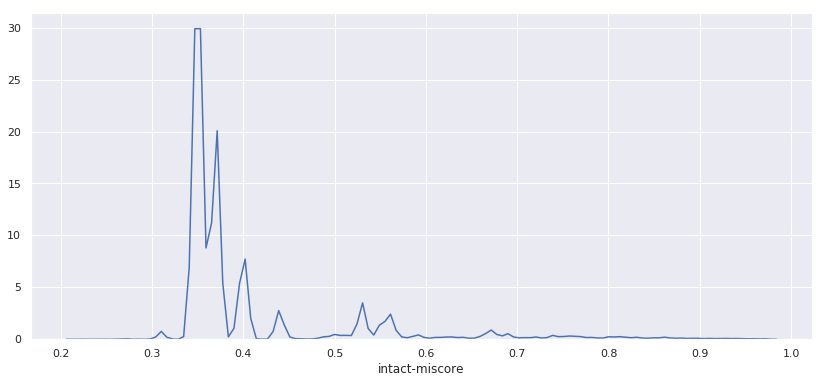

In [68]:
sns.distplot(THEintact['intact-miscore'], hist=False);

*Interaction types*

In [69]:
THEintact.groupby(by="Interaction type(s)").size().sort_values(ascending=False)

Interaction type(s)
psi-mi:"MI:0914"(association)             21424
psi-mi:"MI:0915"(physical association)    20113
psi-mi:"MI:0407"(direct interaction)       1531
dtype: int64

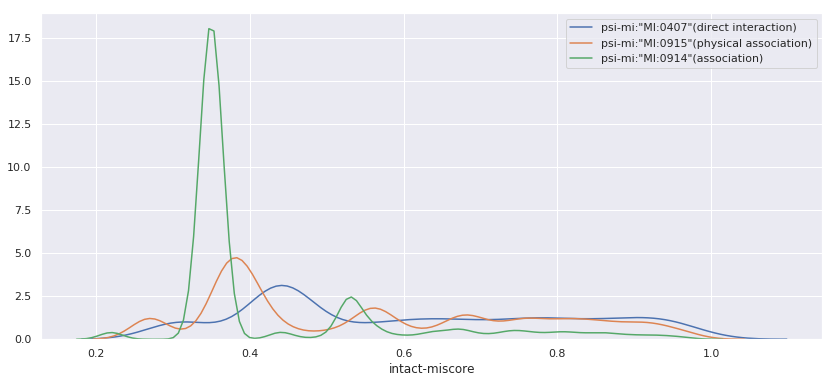

In [70]:
for l in set(THEintact["Interaction type(s)"]):
    foo = dfIntAct1.loc[dfIntAct1['Interaction type(s)'] == l]
    sns.distplot(foo['intact-miscore'], hist=False, label=l)
plt.legend();

*Detection methods*

In [71]:
THEintact.groupby(by="Interaction detection method(s)").size().sort_values(ascending=False)

Interaction detection method(s)
psi-mi:"MI:0676"(tandem affinity purification)                         27980
psi-mi:"MI:0018"(two hybrid)                                            3532
psi-mi:"MI:0397"(two hybrid array)                                      3338
psi-mi:"MI:0111"(dihydrofolate reductase reconstruction)                2625
psi-mi:"MI:0398"(two hybrid pooling approach)                           1121
psi-mi:"MI:0112"(ubiquitin reconstruction)                              1000
psi-mi:"MI:0007"(anti tag coimmunoprecipitation)                         929
psi-mi:"MI:0096"(pull down)                                              595
psi-mi:"MI:0089"(protein array)                                          515
psi-mi:"MI:0363"(inferred by author)                                     499
psi-mi:"MI:0081"(peptide array)                                          284
psi-mi:"MI:0006"(anti bait coimmunoprecipitation)                        122
psi-mi:"MI:0004"(affinity chromatography tec

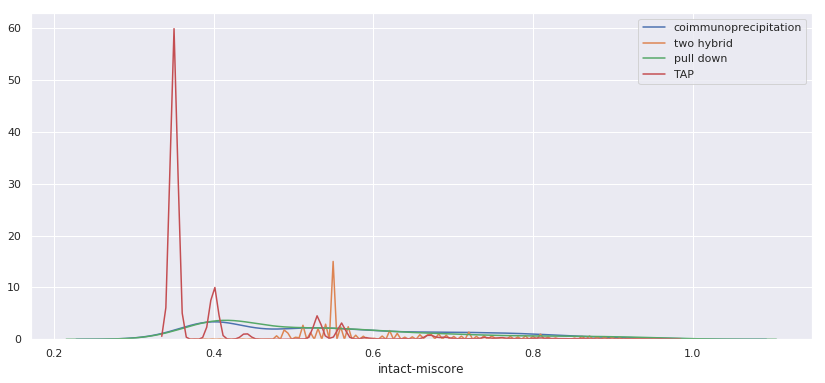

In [72]:
l1 = [
    'psi-mi:"MI:0007"(anti tag coimmunoprecipitation)',
    'psi-mi:"MI:0006"(anti bait coimmunoprecipitation)',
]
foo = THEintact.loc[THEintact['Interaction detection method(s)'].isin(l1)]

l2 = [
    'psi-mi:"MI:0397"(two hybrid array)', 
    'psi-mi:"MI:1112"(two hybrid prey pooling approach)',
    'psi-mi:"MI:1356"(validated two hybrid)',
    'psi-mi:"MI:0018"(two hybrid)'
]
bar = THEintact.loc[THEintact['Interaction detection method(s)'].isin(l2)]

l3 = ['psi-mi:"MI:0096"(pull down)',]
baar = THEintact.loc[THEintact['Interaction detection method(s)'].isin(l3)]

l4 = ['psi-mi:"MI:0676"(tandem affinity purification)',]
fool = THEintact.loc[THEintact['Interaction detection method(s)'].isin(l4)]

sns.distplot(foo['intact-miscore'], hist=False, label='coimmunoprecipitation')
sns.distplot(bar['intact-miscore'], hist=False, label='two hybrid')
sns.distplot(baar['intact-miscore'], hist=False, label='pull down')
sns.distplot(fool['intact-miscore'], hist=False, label='TAP')
plt.legend();

# Export tables


- v1.0 used IntAct v20211015

In [76]:
intact_export = THEintact.copy()

intact_export = intact_export[[
    'uniprotID_A',
    'uniprotID_B',
    'intact-miscore'
]].reset_index(drop=True)

glance(intact_export)

DataFrame: 43,068 rows 	 3 columns


,uniprotID_A,uniprotID_B,intact-miscore
0,P04050,P38827,0.22
1,P15019,P53228,0.22
2,P46970,Q03214,0.27
3,P17558,P38972,0.27
4,P53173,Q12234,0.27


In [77]:
versionINTACTall = '1-0'

In [78]:
logVersions['IntAct']['preprocessed']['yeast'] = versionINTACTall

dump_LogVersions(logVersions)

In [79]:
intact_export.to_pickle(os.path.join(cfg['outputPreprocessingIntAct'], 
                                     "intact_yeast_allScores_v{}.pkl".format(versionINTACTall)))


## Create an index of the number of interactions per protein

Based on the unfiltered dataset

In [80]:
intact_export = pd.read_pickle(
    os.path.join(cfg['outputPreprocessingIntAct'], 
                 "intact_yeast_allScores_v{}.pkl".format(logVersions['IntAct']['preprocessed']['yeast']))
)
glance(intact_export)

DataFrame: 43,068 rows 	 3 columns


,uniprotID_A,uniprotID_B,intact-miscore
0,P04050,P38827,0.22
1,P15019,P53228,0.22
2,P46970,Q03214,0.27
3,P17558,P38972,0.27
4,P53173,Q12234,0.27


In [81]:
allIDs_all = pd.concat([intact_export.uniprotID_A,intact_export.uniprotID_B])

In [82]:
Ninter_perProtein = allIDs_all.value_counts().to_dict()
glance(Ninter_perProtein)


-- P11484: <class 'int'>
3285

-- P10591: <class 'int'>
2524

-- P32589: <class 'int'>
1959

-- P10592: <class 'int'>
1957

-- P40150: <class 'int'>
1243


**Export**

In [83]:
path0 = os.path.join(
    cfg['outputPreprocessingIntAct'], 
    "Ninter_perProtein_intact_yeast_allScores_v{}.pkl".format(logVersions['IntAct']['preprocessed']['yeast'])
)

with open(path0, 'wb') as f:
    pkl.dump(Ninter_perProtein, f, protocol=pkl.HIGHEST_PROTOCOL)

## Create "official" list of hubs

Based on the literature, definition of top 20% in the unfiltered (but cleaned) dataset

In [84]:
foo = allIDs_all.value_counts()

print(foo.describe(percentiles = [0.8]))

print(f"")

count    5679.000000
mean       15.167459
std        75.410818
min         1.000000
50%         7.000000
80%        17.000000
max      3285.000000
dtype: float64



**Which happens to mean >= 17 interactions**

In [85]:
top20p = list(foo.loc[foo >= 17].index)
glance(top20p)

len: 1195
['P11484', 'P10591', 'P32589', 'P10592', 'P40150']


**Export**

In [86]:
path0 = os.path.join(
    cfg['outputPreprocessingIntAct'], 
    "listHubs_yeast_20p_v{}.pkl".format(logVersions['IntAct']['preprocessed']['yeast'])
)

with open(path0, 'wb') as f:
    pkl.dump(top20p, f, protocol=pkl.HIGHEST_PROTOCOL)

In [87]:
path0

'/rds/user/ll582/hpc-work/PPIdata/output/1_preprocessing/IntAct/listHubs_yeast_20p_v1-0.pkl'